# Exercise 3.2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [ ]:
"""
Simple Simulation of the FrozenLake environment; 
code structure taken from gym documentation. The loop chooses a random action at each time step.
The action is then executed and the environment is rendered. Rendering is delayed by 0.1 seconds after each step,
as otherwise the simulation terminates after <1 second and cannot actually be observed by humans.
"""
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="human")

observation, info = env.reset()  #obligatory reset

episode_over = False
while not episode_over:
    action = env.action_space.sample()  #sample random action (either 0 or 1, left or right)
    observation, reward, terminated, truncated, info = env.step(action)  #action is performed

    print(observation)

    env.render()  #environment is rendered
    time.sleep(0.1)  #delay

    #if either a termination condition is met or the maximum episode length is reached, the loop needs to end
    episode_over = terminated or truncated

env.close()  #close the environment

#### (a)

Initial policy:
    - RIGHT: 35%
    - DOWN: 35%
    - LEFT: 15%
    - UP: 15%

The idea behind this is that as the goal is on the bottom right and the start is on the top left,
the general trend should be to move to the bottom right of the lake.

In [3]:
def initial_policy(observation):
    moves = [0, 1, 2, 3]
    probabilities = [0.15, 0.35, 0.35, 0.15]
    return np.random.choice(moves, p=probabilities)

In [4]:
def run_episode(env, policy):
    
    observation, info = env.reset()  #obligatory reset
    path = [observation]
    rewards = []
    
    episode_over = False
    while not episode_over:
        action = policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)  #action is performed
    
        path.append(observation)
        rewards.append(reward)
    
        #if either a termination condition is met or the maximum episode length is reached,
        #the loop needs to end
        episode_over = terminated or truncated
    
    return path, rewards

In [5]:
def policy_eval(n=100, gamma=0.2):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    
    returns = [[] for _ in range(16)]
    v = np.zeros(16, dtype=float)
    for _ in range(n):
        path, rewards = run_episode(env, initial_policy)
        g = 0
        for t in reversed(range(len(path)-1)):
            g = gamma*g + rewards[t]
            if path[t] not in path[:t]:
                returns[path[t]].append(g)
                v[path[t]] = np.average(returns[path[t]])
    
    env.close()
    return v

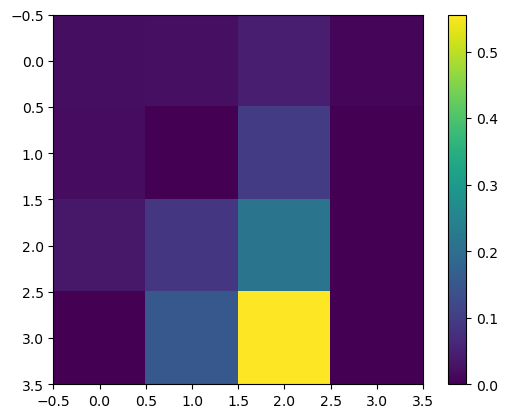

In [6]:
heatmap = policy_eval(n=1000, gamma=1)
plt.imshow(heatmap.reshape(4,4))
plt.colorbar()
plt.show()
#print(policy_eval(n=100))

Analysis:
    -   A state value is only the average action value in that state across all actions and the policy
    -   However, if the state has an action that guarantees a reward (e.g. the action to the left of the goal, 
        in this case with a value of ~0.5), that fact is not accurately represented by just the state value function
    -   Similarly, states far from the goal are all evaluated very close to each other in value (in this case 0),
        even though some of them are clearly superior (e.g. tile 6 compared to tile 4), but since the agent generally
        fails to retrieve a reward very often, they have almost the same value.

#### (b)

In [18]:
def run_episode(env, policy):
    observation, info = env.reset()  #obligatory reset
    
    path = [observation]
    rewards = []
    actions = []

    episode_over = False
    while not episode_over:
        action = policy.policy(observation)
        actions.append(action)
        
        observation, reward, terminated, truncated, info = env.step(action)  #action is performed

        path.append(observation)
        rewards.append(reward)

        #if either a termination condition is met or the maximum episode length is reached,
        #the loop needs to end
        episode_over = terminated or truncated

    return path, actions, rewards


In [55]:
class Policy:
    def __init__(self, n=100, gamma=1):
        self.moves = [0, 1, 2, 3]
        self.v = np.zeros((16, 4), dtype=float)
        self.n = n
        self.gamma = gamma
    
    def policy(self, observation):
        t = np.asarray(self.v[observation] == np.max(self.v[observation])).nonzero()[0]
        return np.random.choice(t)
    
    def policy_eval(self):
        env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

        returns = [[[] for _ in range(4)] for _ in range(16)]
        for _ in range(self.n):
            path, actions, rewards = run_episode(env, self)
            g = 0
            for t in reversed(range(len(path)-1)):
                g = self.gamma * g + rewards[t]
                if (path[t], actions[t]) not in zip(path[:t], actions[:t]):
                    returns[path[t]][actions[t]].append(g)
                    self.v[path[t]][actions[t]] = np.average(returns[path[t]][actions[t]])

        return self.v

In [59]:
policy = Policy(n=100000)
print(policy.policy_eval())

[[0.03703704 0.03773585 0.04261131 0.        ]
 [0.         0.         0.03591    0.        ]
 [0.07238597 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.04939629 0.        ]
 [0.         0.         0.         0.        ]
 [0.10802526 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.10496042 0.         0.        ]
 [0.         0.21151133 0.         0.        ]
 [0.         0.         0.24994331 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.28380062]
 [0.         0.64296498 0.         0.        ]
 [0.         0.         0.         0.        ]]
